In [1]:
# 加载音乐
import librosa
x , sr = librosa.load("./dataset/test.mp3", sr=8000)
print(x.shape, sr)

/home/tzr/anaconda3/envs/RockLab/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(2132521,) 8000


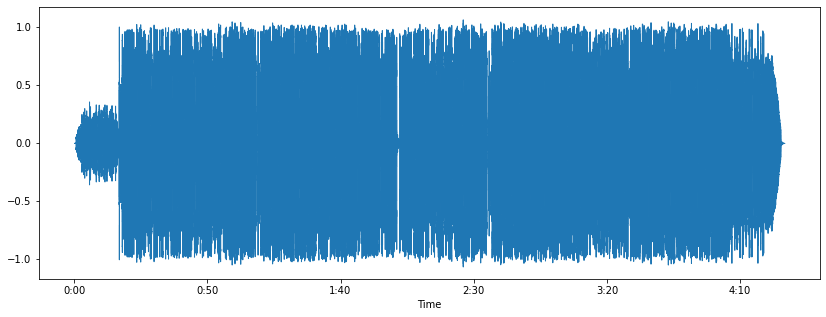

In [2]:
# matplotlib 导入
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

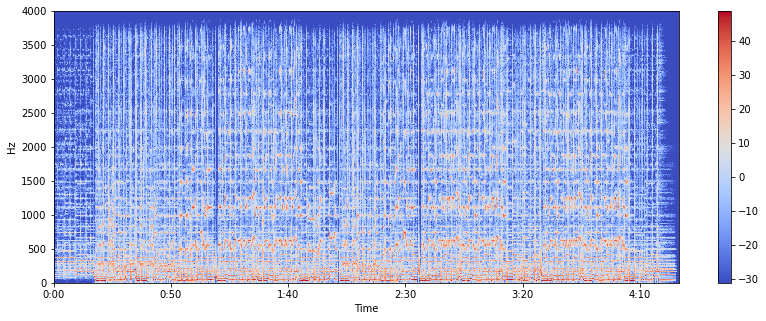

In [3]:
# 短时傅立叶变换
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))   # 把幅度转成分贝格式
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
# 横轴是时间，纵轴是频率，颜色则代表分贝（声音的响度），可以看到越红的地方信号音量越大。

### 特征提取  
**过零率（Zero Crossing Rate）**  
过零率(Zero Crossing Rate,ZCR)是指在每帧中,语音信号通过零点(从正变为负或从负变为正)的次数。这个特征已在语音识别和音乐信息检索领域得到广泛使用，是金属声音和摇滚乐的关键特征。




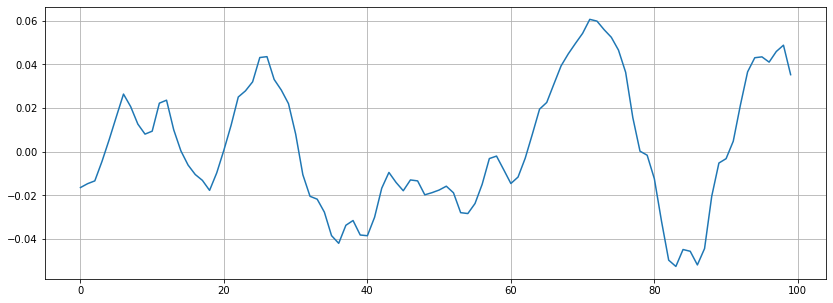

In [4]:
# 根据上面一个图把一个时间上放大。
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [5]:
# 打印过零点
zero_crosssings = librosa.zero_crossings(x[n0:n1],pad=False)
print(sum(zero_crosssings))

7


**频谱中心（Spectral Centroid）**  
频谱中心代表声音的“质心”，又称为频谱一阶距。频谱中心的值越小，表明越多的频谱能量集中在低频范围内。

/tmp/ipykernel_2292541/2313340316.py:10: FutureWarning: Pass y=[0.         0.         0.         ... 0.16436802 0.10792373 0.0710531 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(x[:80000], sr=sr)[0]


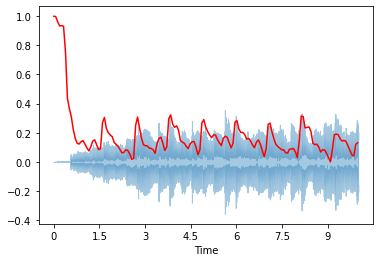

In [6]:
# 这里用x[:80000]表示音乐的前10秒。

# .spectral_centroid 来计算每一帧的频谱中心。

# .frames_to_time将帧转换为时间，time[i] == frame[i]。【因为stft是一个窗口(帧)一个窗口取的，和采样频率并不对应，所以有个转换】

# 为了更好的可视化，对频谱中心进行了归一化。
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x[:80000], sr=sr)[0]
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames, sr=8000)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x[:80000], sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

**频谱滚降点（Spectral Rolloff）**  
频谱滚降点的意思:比该频率低的频率的所有能量大于一定比例的整个频谱的能量，通常这个比例为0.85。

公式:

![equal1](./img/rolloff.png)

/tmp/ipykernel_2292541/2022685455.py:1: FutureWarning: Pass y=[0.         0.         0.         ... 0.16436802 0.10792373 0.0710531 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_rolloff = librosa.feature.spectral_rolloff(x[:80000], sr=sr)[0]


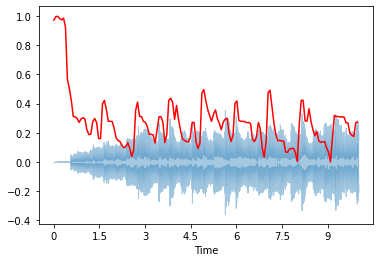

In [7]:
spectral_rolloff = librosa.feature.spectral_rolloff(x[:80000], sr=sr)[0]
librosa.display.waveshow(x[:80000], sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

**MFCC (梅尔频率倒谱系数)**  
MFCC是音频信号特征中最重要的一个，基本上处理音频信号就会用到。
信号的MFCC参数是一个小集合的特征（一般10-20个），它能够简洁的表示频谱的包络。


(20, 4166)


/tmp/ipykernel_2292541/2402827702.py:4: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(x, sr=sr)


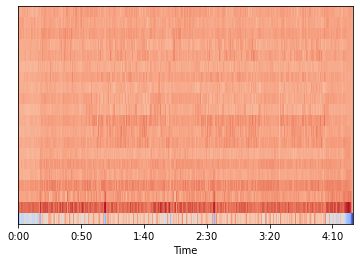

In [8]:
# .mfcc 用来计算信号的MFCC参数。

# 通过打印mfccs.shape，可以看看每一帧里面有多少维的MFCC特征。第一个参数是mfcc参数的维度，第二个参数是帧数。
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [9]:
# 这里一共3177帧，每一帧有20维特征。


## Keras

In [10]:
# 加载数据
import librosa
import numpy as np
import os
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
data_set = []
label_set = []
label2id = {genre:i for i,genre in enumerate(genres)}
id2label = {i:genre for i,genre in enumerate(genres)}
print(label2id)
for g in genres:
    print(g)
    for filename in os.listdir(f'./dataset/genres/{g}/'):
        songname = f'./dataset/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        data_set.append([float(i) for i in to_append.split(" ")])
        label_set.append(label2id[g])

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock


In [11]:
# 创建数据集
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data_set, dtype=float))
y = np_utils.to_categorical(np.array(label_set))
print("x.shape:", y.shape,"y.shape:", y.shape)


x.shape: (1000, 10) y.shape: (1000, 10)


In [12]:
# 分割数据集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
# 创建模型
# 这里创建了一个包含三个隐藏层的神经网络，最后一层输出的是分类层，因为是10类，所以最后一层是10个单元。（这里相比原作者的代码多了一层Dropout减少数据过拟合）

from keras import models
from keras.layers import Dense, Dropout


def create_model():
    model = models.Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model


model = create_model()


2022-08-13 22:15:00.652545: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-13 22:15:00.653599: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-13 22:15:00.654627: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
# 编译模型
# 使用类别交叉熵函数categorical_crossentropy，然后优化器选择Adam，评价指标选择正确率。
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# 训练与评估
# 接下来使用fit方法进行训练，训练50轮。

model.fit(X_train, y_train, epochs=1000, batch_size=256)


2022-08-13 22:15:01.053441: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-13 22:15:01.079633: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/1000
4/4 [==============================] - 1s 6ms/step - loss: 2.3166 - accuracy: 0.1488
Epoch 2/1000
4/4 [==============================] - 0s 2ms/step - loss: 2.1012 - accuracy: 0.3021
Epoch 3/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.9602 - accuracy: 0.3336
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 1.8856 - accuracy: 0.3391
Epoch 5/1000
4/4 [==============================] - 0s 3ms/step - loss: 1.8230 - accuracy: 0.3724
Epoch 6/1000
4/4 [==============================] - 0s 4ms/step - loss: 1.7305 - accuracy: 0.3936
Epoch 7/1000
4/4 [==============================] - 0s 2ms/step - loss: 1.6663 - accuracy: 0.4067
Epoch 8/1000
4/4 [==============================] - 0s 2ms/step - loss: 1.6148 - accuracy: 0.4244
Epoch 9/1000
4/4 [==============================] - 0s 2ms/step - loss: 1.5348 - accuracy: 0.4671
Epoch 10/1000
4/4 [==============================] - 0s 3ms/step - loss: 1.5053 - accuracy: 0.4686
Epoch 11/1000
4/4 

In [16]:
# 使用evaluate方法进行评估
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

7/7 [==============================] - 0s 5ms/step - loss: 2.9894 - accuracy: 0.6850
test_acc:  0.6850000023841858
